# Examining Effect of Class of Device Filtering on the Baseline

The [bluetooth_baselines](bluetooth_baselines.ipynb) notebook identified route closures as contributing to spikes in travel times, because pedestrian devices were being detected by the sensors. This leads one to question whether the presence of pedestrian devices elsewhere might be affecting results elsewhere.

We will first look at Nuit Blanche as an example:

## Nuit Blanche
The Nuit Blanche street closure of Queen affected travel times from Yonge to University overnight from Sep 30th to Oct 1st.


In [1]:
from psycopg2 import connect
import psycopg2.sql as pg
import configparser
import datetime
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(color_codes=True)
from IPython.display import HTML
def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

In [2]:
CONFIG = configparser.ConfigParser()
CONFIG.read('../../db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [13]:
sql = ''' WITH nuit_blanche AS(SELECT cod, device_class FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 19:00' AND analysis_id = 1453719
UNION ALL
SELECT cod, device_class FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 03:00' AND analysis_id = 1453719
)
, nb_total AS (SELECT COUNT(1) as total FROM nuit_blanche  WHERE device_class = 1)
, queen_total AS(SELECT COUNT(1) AS total FROM bluetooth.observations_201709 
WHERE analysis_id = 1453719 AND device_class = 1)
SELECT nb.total AS "Nuit Blanche Observations (No WiFi)",
q.total AS "September Queen Observations  (No WiFi)"
FROM nb_total nb, queen_total q
'''
print_table(sql, con)

Nuit Blanche Observations (No WiFi),September Queen Observations (No WiFi)
135,4627


In [11]:
sql = ''' WITH nuit_blanche AS(SELECT cod, device_class FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 19:00' AND analysis_id = 1453719
UNION ALL
SELECT cod, device_class FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 03:00' AND analysis_id = 1453719
)
, nb_total AS (SELECT COUNT(1) as total FROM nuit_blanche WHERE device_class = 1 )
, nb_counts AS (SELECT cod, device_type, count(1) AS nb_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (Nuit Blanche)"
FROM nuit_blanche
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN nb_total
WHERE device_class = 1
GROUP BY cod, device_type, total
ORDER BY "Proportion of Observations (Nuit Blanche)"

)
, queen_total AS(SELECT COUNT(1) AS total FROM bluetooth.observations_201709 
WHERE analysis_id = 1453719 AND device_class = 1)
, queen_counts  AS (SELECT cod, device_type, count(1) AS queen_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (September)"
FROM bluetooth.observations_201709
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN queen_total
WHERE analysis_id = 1453719 AND device_class = 1
GROUP BY cod, device_type, total
)

SELECT cod, device_type as "Device Type", "Proportion of Observations (Nuit Blanche)", "Proportion of Observations (September)"
FROM queen_counts
INNER JOIN nb_counts USING (cod, device_type)
ORDER BY nb_cnt DESC
LIMIT 15
'''

print_table(sql, con)

cod,Device Type,Proportion of Observations (Nuit Blanche),Proportion of Observations (September)
5898764,Smart phone,45.2%,17.3%
7995916,Smart phone,15.6%,11.6%
2098184,Hands-free Device,11.9%,17.7%
3408904,Hands-free Device,8.1%,16.4%
5898756,Cellular,4.4%,4.9%
5767684,Cellular,3.0%,2.6%
2098180,Wearable Headset Device,1.5%,.7%
7936,none,1.5%,1.9%
2360324,Wearable Headset Device,1.5%,5.0%
3146760,Hands-free Device,1.5%,3.4%


It's odd that the proportion of smartphones shifts between the two sampling periods. 

According to [this Toronto Star Article](https://www.thestar.com/news/gta/2017/09/30/list-of-weekend-road-closures-due-to-nuit-blanche-invictus-games.html), Queen St. was closed from 18:30 until 08:00 the next day. So it is odd that `Hands-free Device` that have previously been reliably identified as exclusively car show up in this timeperiod. Given the sample of ~100 this was around 20 devices  over the 10 hour period.

If one ignores the `device_class` filter, the vendor's identification of whether a device is WiFi or not. The table looks as below.

In [12]:
sql = ''' WITH nuit_blanche AS(SELECT cod, device_class FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 19:00' AND analysis_id = 1453719
UNION ALL
SELECT cod, device_class FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 03:00' AND analysis_id = 1453719
)
, nb_total AS (SELECT COUNT(1) as total FROM nuit_blanche  )
, nb_counts AS (SELECT cod, device_type, count(1) AS nb_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (Nuit Blanche)"
FROM nuit_blanche
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN nb_total
GROUP BY cod, device_type, total
ORDER BY "Proportion of Observations (Nuit Blanche)"

)
, queen_total AS(SELECT COUNT(1) AS total FROM bluetooth.observations_201709 
WHERE analysis_id = 1453719)
, queen_counts  AS (SELECT cod, device_type, count(1) AS queen_cnt, to_char(100.0*COUNT(1)/total, '99.9%') AS "Proportion of Observations (September)"
FROM bluetooth.observations_201709
INNER JOIN bluetooth.class_of_device USING (cod)
CROSS JOIN queen_total
WHERE analysis_id = 1453719
GROUP BY cod, device_type, total
)

SELECT cod, device_type as "Device Type", "Proportion of Observations (Nuit Blanche)", "Proportion of Observations (September)"
FROM queen_counts
INNER JOIN nb_counts USING (cod, device_type)
ORDER BY nb_cnt DESC
LIMIT 15
'''

print_table(sql, con)

cod,Device Type,Proportion of Observations (Nuit Blanche),Proportion of Observations (September)
0,WiFi,96.1%,88.5%
5898764,Smart phone,1.8%,2.1%
7995916,Smart phone,.6%,1.4%
2098184,Hands-free Device,.5%,2.1%
3408904,Hands-free Device,.3%,2.0%
5898756,Cellular,.2%,.6%
5767684,Cellular,.1%,.3%
7936,none,.1%,.2%
2360324,Wearable Headset Device,.1%,.6%
3146760,Hands-free Device,.1%,.4%


In [8]:
sql = '''WITH nuit_blanche AS(SELECT cod, measured_timestamp, measured_time FROM bluetooth.observations_201709 
WHERE measured_timestamp > '2017-09-30 5:30' AND analysis_id = 1453719 AND outlier_level = 0
UNION ALL
SELECT cod, measured_timestamp, measured_time FROM bluetooth.observations_201710 
WHERE measured_timestamp < '2017-10-01 21:00' AND analysis_id = 1453719 AND outlier_level = 0)

SELECT measured_timestamp, measured_time, device_type
FROM nuit_blanche
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE device_type IN ('WiFi', 'Hands-free Device', 'Cellular', 'Smart phone') AND cod > 0  
'''

nuit_blanche = pandasql.read_sql(sql, con)

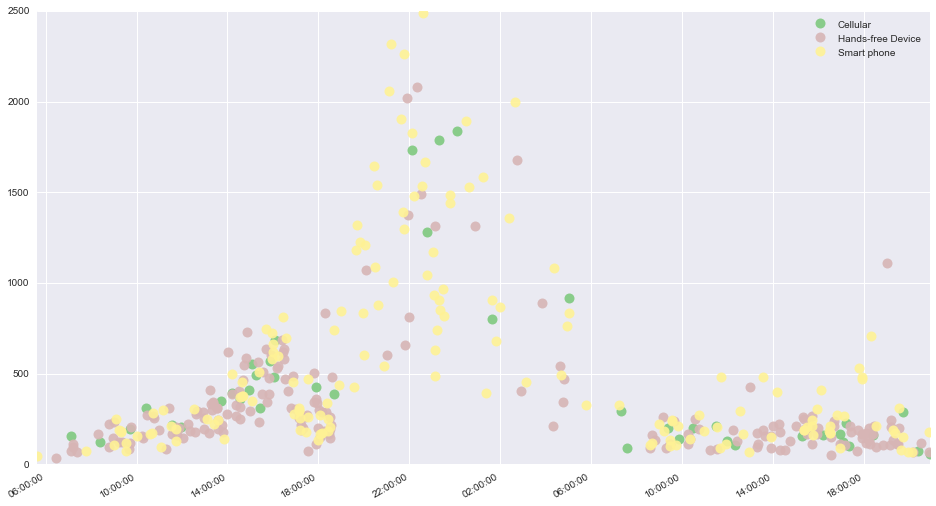

In [9]:
NUM_COLORS = 3
groups = nuit_blanche.groupby('device_type')

fig, ax = plt.subplots(1,1,figsize=(16,9))
NUM_COLORS = 5
cm = plt.get_cmap('Accent')
colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

for i, (device_type, data) in enumerate(groups):
    ax.plot(data.measured_timestamp, data.measured_time, marker='o', markersize=10,
            alpha=0.9, linestyle='', label=device_type, color=colors[i])
ax.legend()
plt.gcf().autofmt_xdate()

The chart above is **inconclusive**. Observations are all over the place between 18:30 and 08:00 when the street was closed to traffic. It excludes the 96% of observations from WiFi devices.
Google Maps gives the minimum walking time from University to Yonge on Queen St. as **420 seconds**, which is below every observation in that time period. 
We can see right before 18:30 a cluster of Hands-free and Smart phone observations closer to the **120 seconds** driving time according to Maps.

In [ ]:
sql = ''' SELECT user_id, route_name, measured_timestamp, measured_time/ 60
FROM bluetooth.observations_201709 
INNER JOIN (SELECT cod, user_id FROM bluetooth.observations_201709 
INNER JOIN bluetooth.class_of_device USING (cod)
WHERE measured_timestamp > '2017-09-30 18:30' AND analysis_id IN (1453719, 1453627) AND device_type = 'Hands-free Device') hfd USING (cod, user_id)
INNER JOIN bluetooth.all_analyses USING (analysis_id)
WHERE measured_timestamp > '2017-09-30 18:30'
ORDER BY user_id, measured_timestamp'''

## Device type & Baseline
